# 导入库函数

In [50]:
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Source Han Sans SC'
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

import string
import pickle

# 中文处理
import langconv
import jieba

# 评价指标
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import single_meteor_score
from rouge import Rouge

# 准备数据集

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in lines]
    return pairs

# 将繁体转为简体
def simple2tradition(line):
    line = langconv.Converter('zh-hans').convert(line)
    return line

# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # 中文标点+数字
    table = str.maketrans('', '', string.digits+' '+'"')
    for pair in lines:
        clean_pair = list()
        
        # 处理英文
        line = pair[0]
        # normalize unicode characters
        line = unicodedata.normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # 在单词与跟在其后的标点符号之间插入一个空格
        line = re.sub(r"([?.!,¿])", r" \1 ", line)
        line = re.sub(r'[" "]+', " ", line)
        # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
        line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)
        line = line.rstrip().strip()
        # convert to lowercase
        line = line.lower()
        # store as string
        clean_pair.append('<start> '+line+' <end>')

        # 处理中文
        line = pair[1]
        # 删去数字
        line = line.translate(table)
        # 英文标点替换
        line = line.replace(',', '，')
        line = line.replace('.', '。')
        line = line.replace('!', '！')
        line = line.replace('?', '？')
        # 未翻译文字翻译
        line = line.replace('Tom', '汤姆')
        line = line.replace('tom', '汤姆')
        line = line.replace('Mary', '玛丽')
        line = line.replace('Facebook', '脸书')
        line = line.replace('CD', '光盘')

        line = simple2tradition(line)
        # line = [re_print.sub('', w) for w in line]
        # clean_pair.append(''.join(line))
        line = jieba.cut(line)
        clean_pair.append('<start> '+' '.join(line)+' <end>')

        cleaned.append(clean_pair)
    return np.array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    pickle.dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [3]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_english(w):
    w = unicode_to_ascii(w.lower().strip())
    # 在单词与跟在其后的标点符号之间插入一个空格
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
def preprocess_chinese(w):
    table = str.maketrans('', '', string.digits+' '+'"')
    # 删去数字、空格和引号
    w = w.translate(table)
    # 英文标点替换
    w = w.replace(',', '，')
    w = w.replace('.', '。')
    w = w.replace('!', '！')
    w = w.replace('?', '？')
    # 未翻译文字翻译
    w = w.replace('Tom', '汤姆')
    w = w.replace('tom', '汤姆')
    w = w.replace('Mary', '玛丽')
    w = w.replace('Facebook', '脸书')
    w = w.replace('CD', '光盘')

    w = langconv.Converter('zh-hans').convert(w)
    w = jieba.cut(w)
    w = ' '.join(w)
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
cn_sentence = u"我能藉你的書嗎？"
print(preprocess_english(en_sentence))
print(preprocess_chinese(cn_sentence))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/3v/sx4fg6vs0hx7q4vw2mcxcpp40000gn/T/jieba.cache
<start> may i borrow this book ? <end>
Loading model cost 0.842 seconds.
Prefix dict has been built successfully.
<start> 我能 藉 你 的 书 吗 ？ <end>


In [6]:
def create_dataset(path, num_examples):
    # 读入行 以回车分割
    doc = io.open(path, encoding='UTF-8').read()
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in lines]
    # 按行处理
    clean_en = list()
    clean_cn = list()
    for pair in pairs[:num_examples]:
        clean_en.append(preprocess_english(pair[0]))
        clean_cn.append(preprocess_chinese(pair[1]))
    return clean_en, clean_cn

In [7]:
path_to_file = 'cmn.txt'
clean_en, clean_cn = create_dataset(path_to_file, None)
print(clean_en[-1])
print(clean_cn[-1])

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如果 一个 人 在 成人 前 没有 机会 习得 目标语言 ， 他 对 该 语言 的 认识 达到 母语 者 程度 的 机会 是 相当 小 的 。 <end>


In [8]:
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_en[i], clean_cn[i]))

[<start> hi . <end>] => [<start> 嗨 。 <end>]
[<start> hi . <end>] => [<start> 你好 。 <end>]
[<start> run . <end>] => [<start> 你 用 跑 的 。 <end>]
[<start> wait ! <end>] => [<start> 等等 ！ <end>]
[<start> wait ! <end>] => [<start> 等 一下 ！ <end>]
[<start> hello ! <end>] => [<start> 你好 。 <end>]
[<start> i try . <end>] => [<start> 让 我 来 。 <end>]
[<start> i won ! <end>] => [<start> 我 赢 了 。 <end>]
[<start> oh no ! <end>] => [<start> 不会 吧 。 <end>]
[<start> cheers ! <end>] => [<start> 干杯 ！ <end>]
[<start> got it ? <end>] => [<start> 你 懂 了 吗 ？ <end>]
[<start> he ran . <end>] => [<start> 他 跑 了 。 <end>]
[<start> hop in . <end>] => [<start> 跳进来 。 <end>]
[<start> i quit . <end>] => [<start> 我 退出 。 <end>]
[<start> i m ok . <end>] => [<start> 我 没事 。 <end>]
[<start> listen . <end>] => [<start> 听 着 。 <end>]
[<start> no way ! <end>] => [<start> 不 可能 ！ <end>]
[<start> no way ! <end>] => [<start> 没门 ！ <end>]
[<start> really ? <end>] => [<start> 你 确定 ？ <end>]
[<start> try it . <end>] => [<start> 试试 吧 。 <end>]
[<sta

# 划分训练集和测试集

In [9]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [11]:
def load_dataset(num_examples=None):
    # 创建清理过的输入输出对
    targ_lang = clean_en
    inp_lang = clean_cn

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
# 尝试实验不同大小的数据集
# num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

print('English Vocabulary Size: %d' % len(targ_lang.word_index))
print('English Max Length: %d' % max_length_targ)

print('Chinese Vocabulary Size: %d' % len(inp_lang.word_index))
print('Chinese Max Length: %d' % max_length_inp)

English Vocabulary Size: 6235
English Max Length: 38
Chinese Vocabulary Size: 10768
Chinese Max Length: 30


In [13]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_test), len(target_tensor_test))

17660 17660 4415 4415


In [14]:
# 保存数据
def save_tensor(sentences, filename):
    pickle.dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [15]:
save_tensor(input_tensor_train, 'input_tensor_train.pkl')
save_tensor(target_tensor_train, 'target_tensor_train.pkl')
save_tensor(input_tensor_test, 'input_tensor_test.pkl')
save_tensor(target_tensor_test, 'target_tensor_test.pkl')

Saved: input_tensor_train.pkl
Saved: target_tensor_train.pkl
Saved: input_tensor_test.pkl
Saved: target_tensor_test.pkl


In [14]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> 他
436 ----> 似乎
53 ----> 不是
216 ----> 美国
35 ----> 人
3 ----> 。
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
11 ----> he
108 ----> doesn
12 ----> t
624 ----> seem
6 ----> to
38 ----> be
64 ----> an
731 ----> american
3 ----> .
2 ----> <end>


# 创建数据集

In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 30]), TensorShape([64, 38]))

## 编写编码器 （encoder） 和解码器 （decoder） 模型

实现一个基于注意力的编码器 - 解码器模型。关于这种模型，你可以阅读 TensorFlow 的 [神经机器翻译 (序列到序列) 教程](https://github.com/tensorflow/nmt)。本示例采用一组更新的 API。此笔记本实现了上述序列到序列教程中的 [注意力方程式](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)。下图显示了注意力机制为每个输入单词分配一个权重，然后解码器将这个权重用于预测句子中的下一个单词。下图和公式是 [Luong 的论文](https://arxiv.org/abs/1508.04025v5)中注意力机制的一个例子。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

输入经过编码器模型，编码器模型为我们提供形状为 *(批大小，最大长度，隐藏层大小)* 的编码器输出和形状为 *(批大小，隐藏层大小)* 的编码器隐藏层状态。

下面是所实现的方程式：

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

本教程的编码器采用 [Bahdanau 注意力](https://arxiv.org/pdf/1409.0473.pdf)。在用简化形式编写之前，让我们先决定符号：

* FC = 完全连接（密集）层
* EO = 编码器输出
* H = 隐藏层状态
* X = 解码器输入

以及伪代码：

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 *第一个轴*, 因为分数 （score） 的形状是 *(批大小，最大长度，隐藏层大小)*。最大长度 （`max_length`） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
* `context vector = sum(attention weights * EO, axis = 1)`。选择第一个轴的原因同上。
* `embedding output` = 解码器输入 X 通过一个嵌入层。
* `merged vector = concat(embedding output, context vector)`
* 此合并后的向量随后被传送到 GRU

每个步骤中所有向量的形状已在代码的注释中阐明：

In [16]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 30, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 隐藏层的形状 == （批大小，隐藏层大小）
    # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
    # 这样做是为了执行加法以计算分数  
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # 分数的形状 == （批大小，最大长度，1）
    # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
    # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
    attention_weights = tf.nn.softmax(score, axis=1)

    # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 30, 1)


In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
    x = self.embedding(x)

    # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到 GRU
    output, state = self.gru(x)

    # 输出的形状 == （批大小 * 1，隐藏层大小）
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == （批大小，vocab）
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6236)


# 绘制结构图

In [22]:
# inp = tf.keras.layers.Input(shape=(max_length_inp,))

# enc_hidden = encoder.initialize_hidden_state()
# enc_output, enc_hidden = encoder(inp, enc_hidden)

# enc_model = tf.keras.Model(inp, [enc_output, enc_hidden])

# tf.keras.utils.plot_model(enc_model, to_file='enc_model.png', show_shapes=True)

In [23]:
# enc_output = tf.keras.layers.Input(shape=(30, 1024))
# enc_hidden = tf.keras.layers.Input(shape=(1024,))

# tar = tf.keras.layers.Input(shape=(max_length_targ,))

# dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
# dec_hidden = enc_hidden

# outputs = []
# # 教师强制 - 将目标词作为下一个输入
# for t in range(1, tar.shape[1]):
#     # 将编码器输出 （enc_output） 传送至解码器
#     predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
#     outputs.append(predictions)
#     # 使用教师强制
#     dec_input = tf.expand_dims(tar[:, t], 1)

# dec_model = tf.keras.Model([enc_output, enc_hidden, tar], outputs)
# tf.keras.utils.plot_model(dec_model, to_file='dec_model.png', show_shapes=True)

## 定义优化器和损失函数

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 检查点（基于对象保存）

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 训练

1. 将 *输入* 传送至 *编码器*，编码器返回 *编码器输出* 和 *编码器隐藏层状态*。
2. 将编码器输出、编码器隐藏层状态和解码器输入（即 *开始标记*）传送至解码器。
3. 解码器返回 *预测* 和 *解码器隐藏层状态*。
4. 解码器隐藏层状态被传送回模型，预测被用于计算损失。
5. 使用 *教师强制 （teacher forcing）* 决定解码器的下一个输入。
6. *教师强制* 是将 *目标词* 作为 *下一个输入* 传送至解码器的技术。
7. 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [34]:
EPOCHS = 20
loss_list = []

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  loss_list.append(total_loss / steps_per_epoch)
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

KeyboardInterrupt: 

## 翻译

* 评估函数类似于训练循环，不同之处在于在这里我们不使用 *教师强制*。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
* 当模型预测 *结束标记* 时停止预测。
* 存储 *每个时间步的注意力权重*。

请注意：对于一个输入，编码器输出仅计算一次。

In [27]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_chinese(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [28]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [29]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 恢复最新的检查点并验证

In [30]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(os.path.join(checkpoint_dir, "ckpt-10"))

In [31]:
inp_lang.word_index['。']

3

Input: <start> 我 是 一名 学生 。 <end>
Predicted translation: i m a student . <end> 


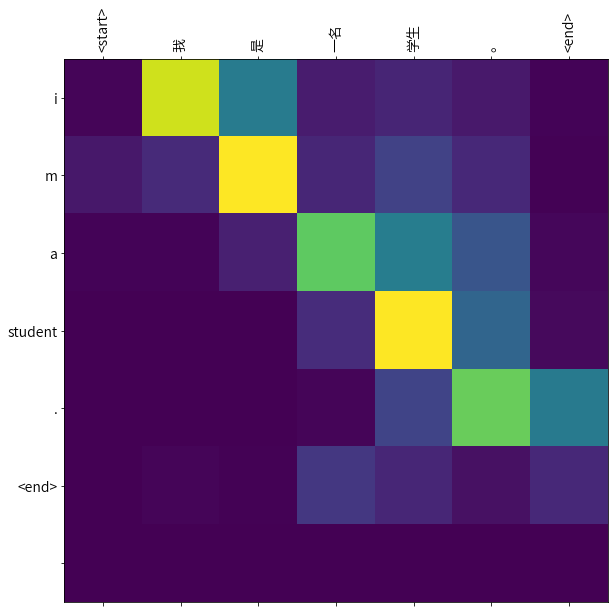

In [32]:
translate(u'我是一名学生。')

Input: <start> 你好 吗 ？ <end>
Predicted translation: how are you ? <end> 


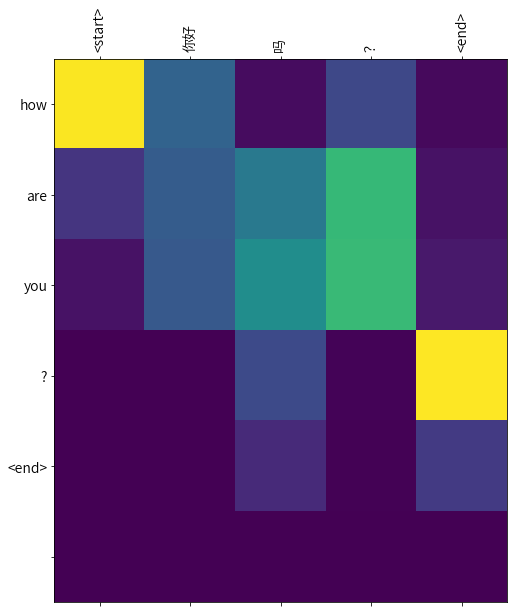

In [33]:
translate(u'你好吗？')

# 计算 Bleu

In [34]:
# 读取数据
def load_tensor(filename):
    return pickle.load(open(filename, 'rb'))

In [35]:
input_tensor_test = load_tensor('input_tensor_test.pkl')
target_tensor_test = load_tensor('target_tensor_test.pkl')

In [36]:
def tensor_sentense(tensor, token):
    sentense = ''
    for t in range(len(tensor)):
        id = tensor[t]
        sentense += token.index_word[id] + ' '
        if token.index_word[id] == '<end>':
            return sentense

    return sentense

def predict_sentense(inputs):
    inputs = tf.expand_dims(inputs, axis=0)
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [37]:
print('输入中文 ', tensor_sentense(input_tensor_test[3], inp_lang))
print('实际英文 ', tensor_sentense(target_tensor_test[3], targ_lang))
print('预测英文 ', predict_sentense(input_tensor_test[3]))
len(input_tensor_test)

输入中文  <start> 看 外面 正在 发生 什么 。 <end> 
实际英文  <start> look at what s happening outside . <end> 
预测英文  look , what happened . <end> 


4415

In [52]:
actual, predicted = list(), list()
for i in range(len(input_tensor_test)):
	raw_chn = tensor_sentense(input_tensor_test[i], inp_lang)
	raw_eng = tensor_sentense(target_tensor_test[i], targ_lang)
	translation = predict_sentense(input_tensor_test[i])
	raw_chn = raw_chn.replace('<start>','').replace('<end>','')
	raw_eng = raw_eng.replace('<start>','').replace('<end>','')
	translation = translation.replace('<start>','').replace('<end>','')
	if i < 10:
		print('输入中文=[%s], 实际英文=[%s], 预测英文=[%s]' % (raw_chn, raw_eng, translation))
	actual.append([raw_eng.split()])
	predicted.append(translation.split())

print(actual[0:2])
print(predicted[0:2])
# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

输入中文=[ 汤姆 的 教室 在 哪里 ？  ], 实际英文=[ where is tom s classroom ?  ], 预测英文=[where s the nearest telephone booth ?  ]
输入中文=[ 汤姆 不 知道 玛丽 有 男朋友 。  ], 实际英文=[ tom didn t know mary had a boyfriend .  ], 预测英文=[tom doesn t know if mary has a boyfriend .  ]
输入中文=[ 请 坐在 沙发 上放 轻松 。  ], 实际英文=[ please sit on the sofa and relax .  ], 预测英文=[please be postponed from the dark .  ]
输入中文=[ 看 外面 正在 发生 什么 。  ], 实际英文=[ look at what s happening outside .  ], 预测英文=[look , what happened .  ]
输入中文=[ 他 这个 时候 该 到 了 。  ], 实际英文=[ this is the time he normally arrives .  ], 预测英文=[he should be coming to bed .  ]
输入中文=[ 我们 几乎 像 兄弟 一样 。  ], 实际英文=[ we re almost like brothers .  ], 预测英文=[we almost love brothers .  ]
输入中文=[ 汤姆 不 知道 玛丽 住 在 哪里 。  ], 实际英文=[ tom doesn t know where mary lives .  ], 预测英文=[tom doesn t know where mary lives .  ]
输入中文=[ 你 想 跟 我 去 野餐 吗 ？  ], 实际英文=[ do you want to go on a picnic with me ?  ], 预测英文=[would you going to go to the picnic with me ?  ]
输入中文=[ 他会 成为 一个 好 的 医生 的 。  ], 实际英文=[ he will be a good doct

KeyboardInterrupt: 

In [ ]:
# epoch = 20
BLEU-1: 0.550518
BLEU-2: 0.392867
BLEU-3: 0.302809
BLEU-4: 0.233100

In [71]:
hypothesis = 'where s the nearest telephone booth ?'
reference = 'where is tom s classroom ?' 

rouge = Rouge()
print(rouge.get_scores(hypothesis, reference, avg=True))
print('METEOR:', single_meteor_score(reference,hypothesis))

{'rouge-1': {'f': 0.4615384565680473, 'p': 0.42857142857142855, 'r': 0.5}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.4615384565680473, 'p': 0.42857142857142855, 'r': 0.5}}
METEOR: 0.24590163934426232


In [51]:
actual, predicted = list(), list()
for i in range(len(input_tensor_test)):
	raw_chn = tensor_sentense(input_tensor_test[i], inp_lang)
	raw_eng = tensor_sentense(target_tensor_test[i], targ_lang)
	translation = predict_sentense(input_tensor_test[i])
	raw_chn = raw_chn.replace('<start>','').replace('<end>','').strip().rstrip()
	raw_eng = raw_eng.replace('<start>','').replace('<end>','').strip().rstrip()
	translation = translation.replace('<start>','').replace('<end>','').strip().rstrip()
	if i < 10:
		print('输入中文=[%s], 实际英文=[%s], 预测英文=[%s]' % (raw_chn, raw_eng, translation))
	actual.append(raw_eng)
	predicted.append(translation)

print(actual[0:2])
print(predicted[0:2])
# calculate Rouge score
rouge = Rouge()
print(rouge.get_scores(predicted, actual, avg=True))

输入中文=[汤姆 的 教室 在 哪里 ？], 实际英文=[where is tom s classroom ?], 预测英文=[where s the nearest telephone booth ?]
输入中文=[汤姆 不 知道 玛丽 有 男朋友 。], 实际英文=[tom didn t know mary had a boyfriend .], 预测英文=[tom doesn t know if mary has a boyfriend .]
输入中文=[请 坐在 沙发 上放 轻松 。], 实际英文=[please sit on the sofa and relax .], 预测英文=[please be postponed from the dark .]
输入中文=[看 外面 正在 发生 什么 。], 实际英文=[look at what s happening outside .], 预测英文=[look , what happened .]
输入中文=[他 这个 时候 该 到 了 。], 实际英文=[this is the time he normally arrives .], 预测英文=[he should be coming to bed .]
输入中文=[我们 几乎 像 兄弟 一样 。], 实际英文=[we re almost like brothers .], 预测英文=[we almost love brothers .]
输入中文=[汤姆 不 知道 玛丽 住 在 哪里 。], 实际英文=[tom doesn t know where mary lives .], 预测英文=[tom doesn t know where mary lives .]
输入中文=[你 想 跟 我 去 野餐 吗 ？], 实际英文=[do you want to go on a picnic with me ?], 预测英文=[would you going to go to the picnic with me ?]
输入中文=[他会 成为 一个 好 的 医生 的 。], 实际英文=[he will be a good doctor .], 预测英文=[he will make a good driver .]
输入中文=[他 供认 了 杀人 的 罪行 。], 

In [ ]:
{'rouge-1': {'f': 0.5178593884949952, 'p': 0.5326023840270103, 'r': 0.5185645882069546}, 'rouge-2': {'f': 0.283772277567112, 'p': 0.2916948885279044, 'r': 0.28456496503168494}, 'rouge-l': {'f': 0.51759913638108, 'p': 0.538642602576883, 'r': 0.5101709789224532}}

In [82]:
hypothesis = predicted[0]
reference = actual[0]
print(hypothesis)
print(reference)
single_meteor_score(reference,hypothesis)

where s the nearest telephone booth ?
where is tom s classroom ?


0.24590163934426232

In [85]:
total_score = 0

for i in range(len(input_tensor_test)):
    hypothesis = predicted[i]
    reference = actual[i]
    total_score += single_meteor_score(reference,hypothesis)
print(total_score / len(input_tensor_test))

0.5083032737375731
